# xarray introduction

Xarray doesn’t just keep track of labels on arrays – it uses them to provide a powerful and concise interface. For example:

- **Apply operations over dimensions by name**: `x.sum('time')`.
- **Select values by label** (or logical location) instead of integer location: `x.loc['2014-01-01']` or `x.sel(time='2014-01-01')`.
- **Mathematical operations** (e.g., `x - y`) vectorize across multiple dimensions (array broadcasting) based on dimension names, not shape.
- Easily use the **split-apply-combine** paradigm with groupby: `x.groupby('time.dayofyear').mean()`.
- **Database-like alignment** based on coordinate labels that smoothly handles missing values: `x, y = xr.align(x, y, join='outer')`.
- Keep track of **arbitrary metadata** in the form of a Python dictionary: `x.attrs`.


## Example
![xarray_example](xarray_example.png)
xarray Datasets consists of data variables and coordinates:

In [29]:
import numpy as np
import pandas as pd
import xarray as xr

np.random.seed(123)

xr.set_options(display_style="html")

# dummy cycle
times = pd.date_range("2019-01-01", "2020-12-31", name="time")
annual_cycle = np.sin(2 * np.pi * (times.dayofyear.values / 365.25 - 0.28))

# create temperature and pressure data for 3 locations (stations)
temperature_base = 10 + 15 * annual_cycle.reshape(-1, 1)
temperature_values = temperature_base + np.random.randn(annual_cycle.size, 3)

pressure_base = 200 + 30 * annual_cycle.reshape(-1, 1)
pressure_values = pressure_base + np.random.randn(annual_cycle.size, 3)


ds = xr.Dataset(
    {
        "temperature": (("time", "station"), temperature_values),
        "pressure": (("time", "station"), pressure_values),
    },
    {"time": times, "station": ["Berlin", "Paris", "Madrid"]},
)

ds

<xarray.Dataset>
Dimensions:      (time: 731, station: 3)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2020-12-31
  * station      (station) <U6 'Berlin' 'Paris' 'Madrid'
Data variables:
    temperature  (time, station) float64 -5.866 -3.783 -4.497 ... -3.644 -4.71
    pressure     (time, station) float64 173.0 169.8 171.0 ... 170.9 169.8 170.0

**Data access via selectors**  
Find the maximum temperature for a given date for all stations

In [30]:
temperature_values[np.where(times == '2020-01-12')].max(axis=1)

array([-4.91007797])

In [31]:
ds.sel(time='2020-01-12').max(dim='station')

<xarray.Dataset>
Dimensions:      ()
Coordinates:
    time         datetime64[ns] 2020-01-12
Data variables:
    temperature  float64 -4.91
    pressure     float64 171.3

## Create a DataArray
You can make a DataArray from scratch by supplying data in the form of a numpy array or list, with optional dimensions and coordinates:

In [33]:
data = xr.DataArray(np.random.randn(2, 3), dims=("x", "y"), coords={"x": [10, 20]})
data

<xarray.DataArray (x: 2, y: 3)>
array([[ 0.0559122 , -2.32168059, -0.12320826],
       [-0.64402167, -0.16766583, -1.51074968]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y

In this case, we have generated a 2D array, assigned the names x and y to the two dimensions respectively and associated two **coordinate labels** `10` and `20` with the two locations along the x dimension.

Here are the key properties for a DataArray:

In [34]:
# like in pandas, values is a numpy array that you can modify in-place
data.values

array([[ 0.0559122 , -2.32168059, -0.12320826],
       [-0.64402167, -0.16766583, -1.51074968]])

In [35]:
data.dims

('x', 'y')

In [36]:
data.coords

Coordinates:
  * x        (x) int64 10 20

In [37]:
# you can use this dictionary to store arbitrary metadata
data.attrs

{}

## Indexing

xarray supports four kinds of indexing. Since we have assigned coordinate labels to the x dimension we can use label-based indexing along that dimension just like pandas. The four examples below all yield the same result (the value at x=10) but at varying levels of convenience and intuitiveness.

In [38]:
# positional and by integer label, like numpy
data[0, :]

<xarray.DataArray (y: 3)>
array([ 0.0559122 , -2.32168059, -0.12320826])
Coordinates:
    x        int64 10
Dimensions without coordinates: y

In [39]:
# loc or "location": positional and coordinate label, like pandas
data.loc[10]

<xarray.DataArray (y: 3)>
array([ 0.0559122 , -2.32168059, -0.12320826])
Coordinates:
    x        int64 10
Dimensions without coordinates: y

In [40]:
# isel or "integer select":  by dimension name and integer label
data.isel(x=0)

<xarray.DataArray (y: 3)>
array([ 0.0559122 , -2.32168059, -0.12320826])
Coordinates:
    x        int64 10
Dimensions without coordinates: y

In [41]:
# sel or "select": by dimension name and coordinate label
data.sel(x=10)

<xarray.DataArray (y: 3)>
array([ 0.0559122 , -2.32168059, -0.12320826])
Coordinates:
    x        int64 10
Dimensions without coordinates: y

Unlike positional indexing, label-based indexing frees us from having to know how our array is organized. All we need to know are the dimension name and the label we wish to index i.e. `data.sel(x=10)` works regardless of whether `x` is the first or second dimension of the array and regardless of whether `10` is the first or second element of `x`. We have already told xarray that `x` is the first dimension when we created data: xarray keeps track of this so we don’t have to. For more, see [Indexing and selecting data](http://xarray.pydata.org/en/stable/user-guide/indexing.html#indexing).

## Attributes (meta data)
While you’re setting up your DataArray, it’s often a good idea to set metadata attributes. A useful choice is to set `data.attrs['long_name']` and `data.attrs['units']` since xarray will use these, if present, to automatically label your plots.

`attrs` is just a Python dictionary, so you can assign anything you wish.

In [42]:
data.attrs["long_name"] = "random velocity"
data.attrs["units"] = "metres/sec"
data.attrs["description"] = "A random variable created as an example."
data.attrs["random_attribute"] = 123

# you can add metadata to coordinates too
data.x.attrs["units"] = "x units"

In [43]:
data

<xarray.DataArray (x: 2, y: 3)>
array([[ 0.0559122 , -2.32168059, -0.12320826],
       [-0.64402167, -0.16766583, -1.51074968]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y
Attributes:
    long_name:         random velocity
    units:             metres/sec
    description:       A random variable created as an example.
    random_attribute:  123

## Computation
Data arrays work very similarly to numpy ndarrays:

In [44]:
data + 10

<xarray.DataArray (x: 2, y: 3)>
array([[10.0559122 ,  7.67831941,  9.87679174],
       [ 9.35597833,  9.83233417,  8.48925032]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y

In [45]:
np.sin(data)

<xarray.DataArray (x: 2, y: 3)>
array([[ 0.05588308, -0.73108584, -0.12289678],
       [-0.60041636, -0.16688137, -0.99819774]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y
Attributes:
    long_name:         random velocity
    units:             metres/sec
    description:       A random variable created as an example.
    random_attribute:  123

In [46]:
data.T

<xarray.DataArray (y: 3, x: 2)>
array([[ 0.0559122 , -0.64402167],
       [-2.32168059, -0.16766583],
       [-0.12320826, -1.51074968]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y
Attributes:
    long_name:         random velocity
    units:             metres/sec
    description:       A random variable created as an example.
    random_attribute:  123

In [47]:
data.sum()

<xarray.DataArray ()>
array(-4.71141382)

However, aggregation operations can use dimension names instead of axis numbers:

In [48]:
data.mean(dim="x")

<xarray.DataArray (y: 3)>
array([-0.29405473, -1.24467321, -0.81697897])
Dimensions without coordinates: y

**Arithmetic operations broadcast based on dimension name**. This means you don’t need to insert dummy dimensions for alignment:

In [49]:
a = xr.DataArray(np.random.randn(3), [data.coords["y"]])
a

<xarray.DataArray (y: 3)>
array([-0.41472255,  1.49575151,  0.19091872])
Coordinates:
  * y        (y) int64 0 1 2

In [50]:
b = xr.DataArray(np.random.randn(4), dims="z")
b

<xarray.DataArray (z: 4)>
array([-1.11839018, -0.45528475,  0.13054879, -2.28584546])
Dimensions without coordinates: z

In [51]:
a + b

<xarray.DataArray (y: 3, z: 4)>
array([[-1.53311273, -0.8700073 , -0.28417376, -2.70056801],
       [ 0.37736133,  1.04046676,  1.6263003 , -0.79009395],
       [-0.92747147, -0.26436603,  0.32146751, -2.09492674]])
Coordinates:
  * y        (y) int64 0 1 2
Dimensions without coordinates: z

It also means that in most cases you do not need to worry about the order of dimensions:

In [52]:
data - data.T

<xarray.DataArray (x: 2, y: 3)>
array([[0., 0., 0.],
       [0., 0., 0.]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y

Operations also align based on index labels:

In [53]:
data[:-1] - data[:1]

<xarray.DataArray (x: 1, y: 3)>
array([[0., 0., 0.]])
Coordinates:
  * x        (x) int64 10
Dimensions without coordinates: y

For more, see [Computation](http://xarray.pydata.org/en/stable/user-guide/computation.html#comput).

## GroupBy
xarray supports grouped operations using a very similar API to pandas (see GroupBy: split-apply-combine):

In [54]:
labels = xr.DataArray(["E", "F", "E"], [data.coords["y"]], name="labels")
labels

<xarray.DataArray 'labels' (y: 3)>
array(['E', 'F', 'E'], dtype='<U1')
Coordinates:
  * y        (y) int64 0 1 2

In [55]:
data.groupby(labels).mean("y")

<xarray.DataArray (x: 2, labels: 2)>
array([[-0.03364803, -2.32168059],
       [-1.07738567, -0.16766583]])
Coordinates:
  * x        (x) int64 10 20
  * labels   (labels) object 'E' 'F'

In [56]:
data.groupby(labels).map(lambda x: x - x.min())

<xarray.DataArray (x: 2, y: 3)>
array([[1.56666188, 0.        , 1.38754142],
       [0.86672801, 2.15401476, 0.        ]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y

## Plotting

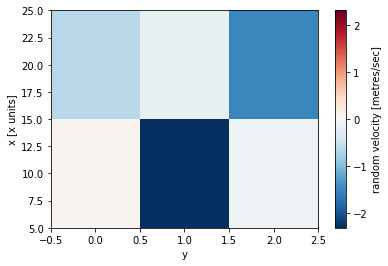

In [57]:
data.plot()